# Learning to Learn by Gradient Descent by Gradient Descent
## As simple as possible in TensorFlow

When I first came across DeepMind’s paper “Learning to learn by gradient descent by gradient descent”, my reaction was “Wow, how on earth does that work?”. Unfortunately, my first read-through of the paper was not that illuminating, and looking at the code was quite daunitng.
Thankfully, I was intrigued enough to force myself to re-read the paper and it actually turned out to be surprisingly simple in the end. Personally, what really helps me when I’m trying to understand something is to create the simplest non-trivial version of the problem and then scale up from there. So here it is, the simplest version of the idea I could create, also no maths equations! I hope you find it illuminating.
I suggest skimming the paper first but this should all be understandable without. Code was ran on TF v1.0.0-rc1.


---

So let’s get started. Time to learn about learning to learn by gradient descent by gradient descent by reading my article.

In [1]:
import tensorflow as tf

In [2]:
tf.GIT_VERSION

'v1.0.0-rc1-0-g114a462-dirty'

First of all we need a problem for our meta-learning optimizer to solve. Let’s take the simplest experiment from the paper; finding the minimum of a multi-dimensional quadratic function. We are going to randomly scale the parabolas and start at random locations, the solution is always at (0, 0).

In [3]:
DIMS = 10  # Dimensions of the parabola
scale = tf.random_uniform([DIMS], 0.5, 1.5)
# This represents the network we are trying to optimize,
# the `optimizee' as it's called in the paper.
# Actually, it's more accurate to think of this as the error
# landscape.
def f(x):
    x = scale*x
    return tf.reduce_sum(x*x)

We can’t easily use TensorFlow’s built in optimizers here since the technique requires us to unroll the training loop inside the computation graph, as we’ll see in a bit. So let’s define a couple of simple hand crafted optimizers to test against our learned optimizer. As discussed in the paper, an optimizer is a function g that takes the gradient of a parameter at a given step and returns back the step you should take in parameter space. Here’s vanilla gradient descent: (Some optimizers need to keep track of state, here I just pass the param through)

In [4]:
def g_sgd(gradients, state, learning_rate=0.1):
    return -learning_rate*gradients, state

For a stronger baseline let’s use RMSProp:

In [5]:
def g_rms(gradients, state, learning_rate=0.1, decay_rate=0.99):
    if state is None:
        state = tf.zeros(DIMS)
    state = decay_rate*state + (1-decay_rate)*tf.pow(gradients, 2)
    update = -learning_rate*gradients / (tf.sqrt(state)+1e-5)
    return update, state

Great, now let’s unroll all the training steps, here learn is a function which takes one of these optimizers and applies it in a loop for number of steps and collects the value of the function f at each point, which we can think of as our loss.

In [6]:
TRAINING_STEPS = 20  # This is 100 in the paper

initial_pos = tf.random_uniform([DIMS], -1., 1.)

def learn(optimizer):
    losses = []
    x = initial_pos
    state = None
    for _ in range(TRAINING_STEPS):
        loss = f(x)
        losses.append(loss)
        grads, = tf.gradients(loss, x)
      
        update, state = optimizer(grads, state)
        x += update
    return losses

OK, now let’s test it out.

In [7]:
sgd_losses = learn(g_sgd)
rms_losses = learn(g_rms)

And see what the losses look like.

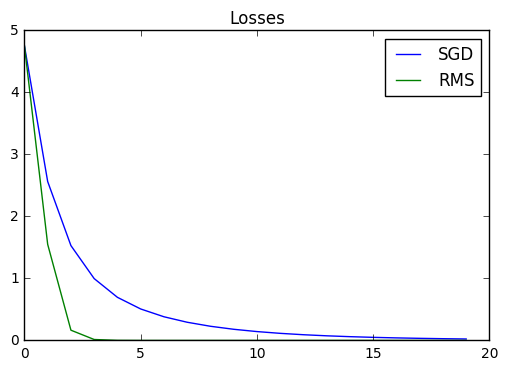

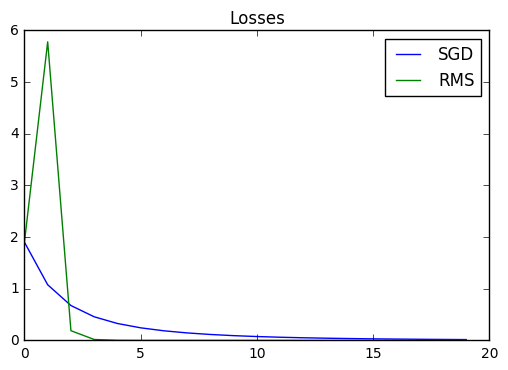

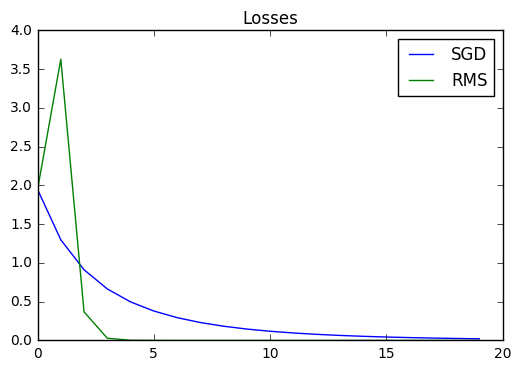

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

x = np.arange(TRAINING_STEPS)
for _ in range(3): 
    sgd_l, rms_l = sess.run([sgd_losses, rms_losses])
    p1, = plt.plot(x, sgd_l, label='SGD')
    p2, = plt.plot(x, rms_l, label='RMS')
    plt.legend(handles=[p1, p2])
    plt.title('Losses')
    plt.show()

## Meta-Learning
Time to put together our meta-learning optimizer, just like in the paper this is an LSTM with 2 layers and 20 hidden units.

In [9]:
LAYERS = 2
STATE_SIZE = 20

cell = tf.contrib.rnn.MultiRNNCell(
    [tf.contrib.rnn.LSTMCell(STATE_SIZE) for _ in range(LAYERS)])
cell = tf.contrib.rnn.InputProjectionWrapper(cell, STATE_SIZE)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 1)
cell = tf.make_template('cell', cell)

def g_rnn(gradients, state):
    # Make a `batch' of single gradients to create a 
    # "coordinate-wise" RNN as the paper describes. 
    gradients = tf.expand_dims(gradients, axis=1)
 
    if state is None:
        state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    update, state = cell(gradients, state)
    # Squeeze to make it a single batch again.
    return tf.squeeze(update, axis=[1]), state

And *that’s it*, that’s our meta learner. We can use it in exactly the same way:

In [10]:
rnn_losses = learn(g_rnn)
sum_losses = tf.reduce_sum(rnn_losses)

Now here’s the magic bit, we want sum_losses to be low, since the lower the losses the better the optimizer right? And because the entire training loop is in the graph we can use Back-Propagation Through Time (BPTT) and a meta-optimizer to minimize this value!

And this is the main point: *sum_losses is differentiable*, gradients flow through the graph we’ve defined just fine! TensorFlow is able to work out the gradients of the parameters in our LSTM with respect to this sum of losses. So let’s optimize:

In [11]:
def optimize(loss):
    optimizer = tf.train.AdamOptimizer(0.0001)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.)
    return optimizer.apply_gradients(zip(gradients, v))

apply_update = optimize(sum_losses)

I found gradient clipping to be *critical* here since the values that go into our meta-learner can be very large at the start of training.

In [12]:
sess.run(tf.global_variables_initializer())

ave = 0
for i in range(4000):
    err, _ = sess.run([sum_losses, apply_update])
    ave += err
    if i % 1000 == 0:
        print(ave / 1000 if i!=0 else ave)
        ave = 0
print(ave / 1000)

53.7043800354
9.93897572911
4.20905622232
3.9845823524
3.92957963991


And see how it does:

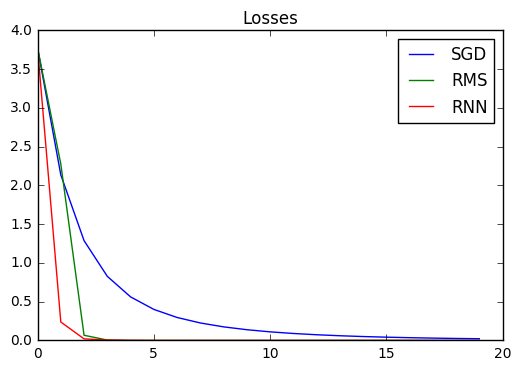

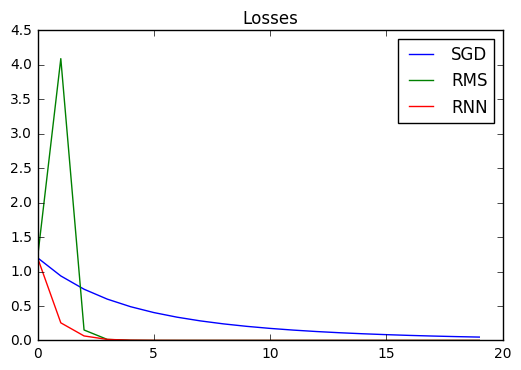

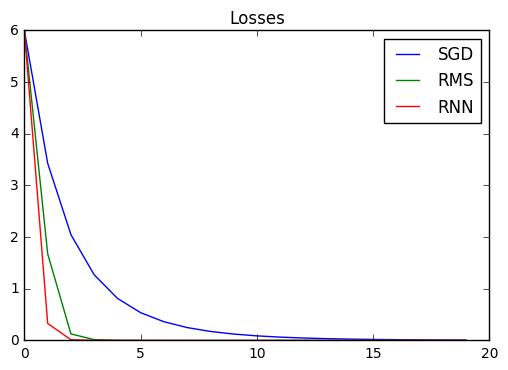

In [13]:
for _ in range(3): 
    sgd_l, rms_l, rnn_l = sess.run(
        [sgd_losses, rms_losses, rnn_losses])
    p1, = plt.plot(x, sgd_l, label='SGD')
    p2, = plt.plot(x, rms_l, label='RMS')
    p3, = plt.plot(x, rnn_l, label='RNN')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()

Success! Looks like it’s doing even better than RMS on this problem. Actually, these graphs are slightly misleading, log scale shows something slightly different:

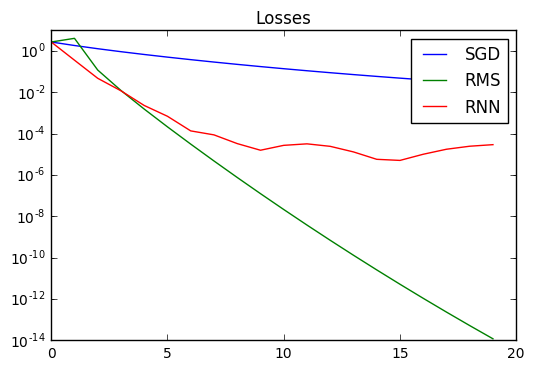

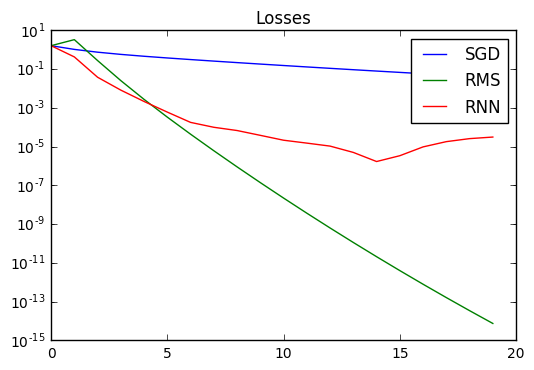

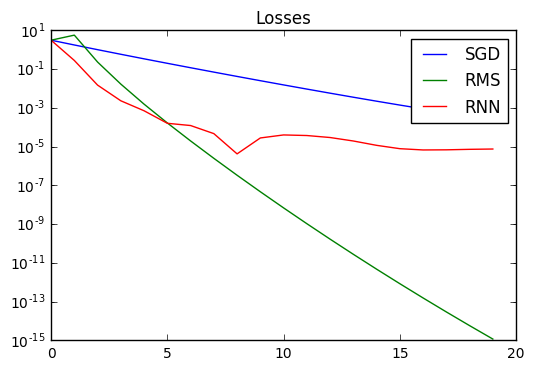

In [14]:
for _ in range(3): 
    sgd_l, rms_l, rnn_l = sess.run(
        [sgd_losses, rms_losses, rnn_losses])
    p1, = plt.semilogy(x, sgd_l, label='SGD')
    p2, = plt.semilogy(x, rms_l, label='RMS')
    p3, = plt.semilogy(x, rnn_l, label='RNN')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()